In [1]:
import os
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
import os.path

In [2]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer

In [4]:
import joblib
import cv2

__Image Processing and Computer Vision: CTA projetc__

Falco Riccardo - riccardo.falco2@tudio.unibo.it - 991986

# The dataset

Task observations hypothesis:
* `pointing = (83.6331, 22.5145)`
* `fov = roi = 5`
* `Time = 100 s`
* `IRF = South_z20_0.5h`
* `Energy = 0.1 - 50 TeV`

First of all let's start to read the dataset

In [5]:
out_models_folder = os.path.join(os.getcwd(), 'models')
base_folder = os.path.join('data', 'dataset')
data_folder_skymap = os.path.join(base_folder, 'skymaps')
tmp_folder = os.path.join(base_folder, 'temp')
if not os.path.isdir(tmp_folder):
    os.mkdir(tmp_folder)
from_pretrained = True

In [6]:
df = pd.read_csv(os.path.join(base_folder,'skymap_set.csv'), index_col=False)
df.head()

,File_name,Source-ra,Source-dec,N_sources,Label
0,crab_sky001.fits,83.594197,21.410309,1,yes
1,crab_sky002.fits,81.112909,21.824453,1,yes
2,crab_sky003.fits,0.000000,0.000000,0,no
3,crab_sky004.fits,85.779273,23.729835,3,yes
4,crab_sky004.fits,82.622388,23.012836,3,yes


Let's rename the column `Label` in a way to make it more human readible. Namely `bkg+source` means that the image contains *backgroud + sources* while instead `bkg_only` means that the image is *background only*  

In [7]:
df['Label'] = df['Label'].apply(lambda x: 'bkg+src' if x =='yes' else 'bkg_only')
df.head()

,File_name,Source-ra,Source-dec,N_sources,Label
0,crab_sky001.fits,83.594197,21.410309,1,bkg+src
1,crab_sky002.fits,81.112909,21.824453,1,bkg+src
2,crab_sky003.fits,0.000000,0.000000,0,bkg_only
3,crab_sky004.fits,85.779273,23.729835,3,bkg+src
4,crab_sky004.fits,82.622388,23.012836,3,bkg+src


Following function plots an example of fits file. It extracts the `WCS` descriptor of the skymap in `file` and plots the image.

In [8]:
def plot_fits_skymap(file, title=None, xlabel='right ascension (deg)', 
                     ylabel='declination (deg)', figsize=(5, 5), fontsize=20, cmap='magma',
                     pointing=None):
    # get map
    with fits.open(file) as hdul:
        wcs = WCS(hdul[0].header)
        data = hdul[0].data

    # plot the simulation image
    fig = plt.figure(figsize=figsize, facecolor='white') 
    ax = plt.subplot(projection=wcs)
    img = plt.imshow(data, norm=SymLogNorm(1), interpolation='gaussian', cmap=cmap)
    ax.coords[0].set_format_unit(u.deg)
    ax.coords[1].set_format_unit(u.deg)
    
    # plot a dot in corrispondance of pointing
    if not pointing == None: 
        ax.scatter(pointing[0], pointing[1], 70, color='green', 
                   edgecolor='white', transform=ax.get_transform('fk5'))

    cb = plt.colorbar(img, ax=ax)
    # axis
    ax.tick_params(axis='both', labelsize=fontsize)
    cb.ax.tick_params(labelsize=fontsize) 
    cb.set_label('counts', fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.grid(color='grey', ls='solid')
    fig.tight_layout()
    hdul.close()
    return 

Here we can see an example of skymap where the small blob represents the gamma ray source. The object of which we want to extract the centroid.

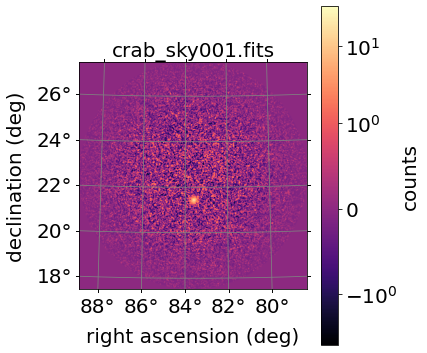

In [9]:
file = os.path.join(data_folder_skymap, 'crab_sky001.fits')
plot_fits_skymap(file, title=os.path.basename(file))

The function `fits2png` is used for converting a file **.fits** in a grayscale **.png** image, in order to work with a precise interval for pixel values [0..255].

In [10]:
def fits2png(img_fits, filename):
    # take the data
    old_img = img_fits.data
    # extract the image shape
    img_shape = old_img.shape[0]
    # extract minimum and maximu pixel values
    old_vmax = np.max(old_img)
    old_vmin = np.min(old_img)
    
    # build the converted image starting by the pixel intensity values of the fits file
    new_img = np.zeros((img_shape, img_shape))
    # reconstructing it in the interval [0..255] (a grayscale image)
    new_vmax = 255
    new_vmin = 0
    # formula for converting .fits pixel to .png
    new_img = np.round( ( (old_img - old_vmin) / (old_vmax - old_vmin) ) * 255)
    
    # save the new .png image
    name=os.path.join(tmp_folder, filename.replace('.fits', '.png'))
    cv2.imwrite(name, new_img)
    return new_img

The `convertDataset` function converts the dataset, which is given as a DataFrame, into a couple of arrays: 
* `X` which contains the PNG images and the filename
* `y` which contains the label (`yes` or `no`) and the number of gamma ray sources 

In [11]:
def convertDataset(df,
                   data_folder=base_folder,
                   data_folder_skymap=None):
    X = []
    Y = []
    filename = ''
    for i in tqdm(range(len(df))):
        curr = df.iloc[i]
        # if the previous row was for the same file, let's skip the iteration
        if filename == curr['File_name']:
            continue
        # otherwise save the current filename 
        filename = curr['File_name']
        
        # checks the path of the skymap file
        if not data_folder_skymap == None:
            skymap = os.path.join(data_folder_skymap, filename)
        else:
            print("ciao")
            skymap = os.path.join(data_folder, filename)
        
        # open the skymap
        hdul = fits.open(skymap)
        # and convert it from .fits to .png
        X.append((fits2png(hdul[0].data, filename), skymap))
        # close the skymap
        hdul.close()
        
        # if it is present at least one gamma ray source
        if curr['Label'] == 'bkg+src':
            # let's save all of them converting them in sky coordinates 
            sources = []
            for j in range(curr['N_sources']):
                sources.append(SkyCoord(df.iloc[i+j]['Source-ra'], 
                                        df.iloc[i+j]['Source-dec'], unit=u.deg))
            Y.append((1, sources))
        else:
            Y.append((0, []))
        
    return (X, Y)

Let's extract from our dataset the features from the output we would like to compute.

In [12]:
(X, y) = convertDataset(df, data_folder_skymap=data_folder_skymap)

100%|██████████| 1250/1250 [02:02<00:00, 10.23it/s]


This histogram shows the _labels_ of the images, meaning the amount of images which hasn't and has got at least one source. As you can see it is a balanced dataset.

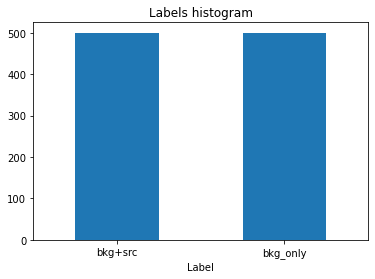

In [13]:
plt.title('Labels histogram')
df.groupby(['File_name', 'Label'], as_index=False).count() \
  .groupby('Label')['Label'].count().plot.bar()
plt.xticks(rotation = 0)
plt.show()

While instead in the following histogram is shown the distribution of the data in the dataset according to the *number of sources* which are present in the same image.

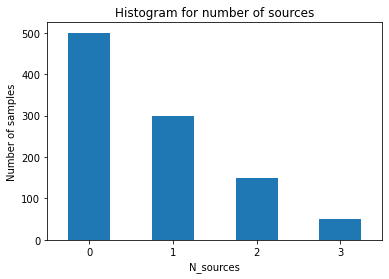

In [14]:
plt.title('Histogram for number of sources')
plt.ylabel('Number of samples')
df.groupby(['File_name', 'N_sources'], as_index=False).count() \
  .groupby('N_sources')['N_sources'].count().plot.bar()
plt.xticks(rotation = 0)
plt.show()

# Methodology 

The general structure of this model can be decomposed in a double distinct but correlated tasks:
* Label classification
* Centroid Coordinates extraction

In order to achieve the best possible result, the idea is to create a distinct and simple classification model based on Support Vector Machines in order to discriminate between `bkg+src` and `bkg_only` images. 

The classificator is a pipeline of trhee main steps
* preprocessing for classification
* Principal Component Analysis with 3 principal component
* Support Vector Machine for label classification

The extractor is instead a pipe of two steps which follow a first step is fixed and it is cìgiven by the pretrained classificator which should predict if the image is `bkg+src` or `bkg_only` (next steps are performed if and only if the image is predicted as `bkg+src`)
* preprocessing of the original image for centroid extraction
* extraction algorithm

<img src="./Images/Architecture.png" width="800"/>

# Label classifier model

First things first, we need to define a "threshold" which is able to identifying images `bkg+soure` and discard images without any sources (`bkg_only`). 

More precisly we need a classification model.

## Preprocessing dataset

Let's now split the dataset in *training set* and *test set* with a test/train ratio of 25%.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [16]:
print("Len training set   ", len(X_train))
print("Len test set       ", len(X_test))

Len training set    750
Len test set        250


And split for both the dataset in a _data_ vector (`X_data_`) and a _file names_ vector (`X_file_`).

In [17]:
X_data_train = np.array([X_train[i][0] for i in range(len(X_train))])
X_file_train = [X_train[i][1] for i in range(len(X_train))]

In [18]:
X_data_test = np.array([X_test[i][0] for i in range(len(X_test))]) 
X_file_test = [X_test[i][1] for i in range(len(X_test))]

Let's do the same for _labels_ vector (`y_label_`) and the _source's coordinates_ vector (`y_coord_`).

In [19]:
y_label_train = [y_train[i][0] for i in range(len(y_train))]
y_coord_train = [y_train[i][1] for i in range(len(y_train))]

In [20]:
y_label_test = [y_test[i][0] for i in range(len(y_test))]
y_coord_test = [y_test[i][1] for i in range(len(y_test))]

### Preprocessing function

In order to get good performances we need to preprocess images.

Image Preprocessing concerns of the following step:
* _Gaussian filter_: in order to denoising the image;
* _Gamma correction_: for intensity transformations;
* _Binary segmentation_: by using thresholding operators. I prefered don't use automatic or adaptive methods because of the properties of the image. It is indeed a very noise and big shape image, where the amount of pixels due to the noise is higher respect to the pixels of sources, resulting in an image which is not clairly bimodal.

In [21]:
def preprocess(X,
               f_treshold, 
               sigma=3.5,
               k_gs_size=-1,
               alpha_power=1):
    X1 = np.copy(X)
    if k_gs_size==-1:
        k_gs_size = int(np.ceil((3*sigma))*2+1)
    # Gaussian blur
    X1 = cv2.GaussianBlur(X1, (k_gs_size,k_gs_size), sigma)
    # Gamma correction
    X1 = cv2.convertScaleAbs(X1, alpha=alpha_power)
    # Computing the threshold
    T = f_treshold(X1)
    # Binary segmentation
    ret2, X1 = cv2.threshold(X1,T,255,cv2.THRESH_BINARY)
    return X1

### 2 different kind of preprocessing

About preprocessing, I designed a parametric function for preprocess which can be splitted two different classes:

* _preprocess for label classification_: in this case the preprocess is designed in a way which allows to extract at least one sources, if it is present. 
 * Indeed the threshold applyied is `thresh4Label` which extracts as threshold the pixel value obtained by subtracting a small fixed pixel window from the maximum value of the current image. 
 * In this step it is not important to understand how many sources there are, I would just know if there is or there isn't a source. 
 
$\Rightarrow$ In this way it is possible to allow the classifier to work more easily.

In [22]:
# this threshold is used for Label classification
def thresh4Label(img, eps=1):
    return np.max(img)-eps

* _preprocess for centroids extraction_: after checking there is at least a source inside the image, we would like to extract centroids of sources that are inside it. 
 * To complete this task, it is applyed to the original image a different preprocessing which instead use the threshold computed by  `threshExtractSource`. 
 * In this case I try to extract pixels which appartain only to all the sources of gamma ray inside image, considering a percentage of pixels value inside image histograms. 

In [23]:
# this function extract the pixel value which values amount corresponds to a given 
# percentage inside the histogram of the image
def find_percentile_value(hist, percentile):
    s = 0
    idx = 0
    total_pixel = np.sum(hist)
    while(s < total_pixel*percentile/100):
        s += hist[idx]
        idx += 1
    return idx

In [24]:
# this threshold is used instead for extract sources centroids
def thresh4SrcExtraction(img, p=90, c=10):
    hist, bins = np.histogram(img.astype(np.uint8).flatten(),256,[0,256])
    v = find_percentile_value(hist, p)
    T = v + c
    return T

**N.B.**: I couldn't use the other threshold, due to the fact that the previous one is focused to extract _at least one_ source, and this is because of the pixel selection window from the maximum value. Indeed using the same previous threshold would have involved, in images with a lot number gamma ray sources but with someone with a low intensity, in misdetecting low intesity sources. Consequently, a huge amount of _False Negative_.

In [25]:
sigma=6
k_gs_size=15
alpha_power=1 # no gamma correction
p=98
eps_seg=15

In [26]:
# preproces lambda function definition for label classification, 
# implementing threshIsPresent with epsilon value equal to eps_seg
preprocess_SVM = lambda x: preprocess(x,
                                      lambda x: thresh4Label(x, eps=eps_seg),
                                      sigma=sigma, 
                                      k_gs_size=k_gs_size,
                                      alpha_power=alpha_power)

In [27]:
# preproces lambda function definition for sources extraction, 
# implementing threshExtractSource with percentage value equal to 98%
preprocess_EXS = lambda x: preprocess(x,
                                      lambda x: thresh4SrcExtraction(x, p=p),
                                      sigma=sigma, 
                                      k_gs_size=k_gs_size,
                                      alpha_power=alpha_power)

#### Comparison between the two thresholds

Let's select an image.

In [28]:
def plot(img, title):
    plt.figure()
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.colorbar()
    plt.title(title)
    plt.show()

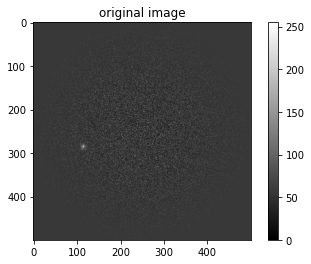

In [29]:
file = os.path.join(tmp_folder, 'crab_sky094.png')
img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
plot(img, title='original image')

In [30]:
def plotThresholds(img, sigma=3.5,k_gs_size=-1,alpha_power=1,p=80,eps=3):
    if k_gs_size==-1:
        k_gs_size = int(np.ceil((3*sigma))*2+1)
    # Gaussian blur
    img1 = cv2.GaussianBlur(img, (k_gs_size,k_gs_size), sigma)
    # Gamma correction
    img1 = cv2.convertScaleAbs(img1, alpha=alpha_power)
    # Computing the threshold
    T1    = thresh4Label(img1, eps=eps_seg)
    T2    = thresh4SrcExtraction(img1, p=p)
    TO, _ = cv2.threshold(img1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=70, )
    fig.subplots_adjust(hspace=0.3)
    for i in range(3):
        hist, bins = np.histogram(img1.astype(np.uint8).flatten(),256,[0,256])
        ax[i].vlines(np.max(img1), 0, np.max(hist), colors='tab:red', label='max')
        ax[i].vlines(T1, 0, np.max(hist), colors='tab:green', label='T1')
        ax[i].vlines(T2, 0, np.max(hist), colors='tab:orange', label='T2')
        ax[i].grid(True)
        ax[i].set_xlabel('Pixel intensity')
        ax[i].set_ylabel('Number of pixel (Log scale)')
        ax[i].plot(hist, color='black', lw=1)
    for i in range(1,3):
        ax[i].vlines(TO, 0, np.max(hist), colors='tab:blue', label='OTSU')
    ax[2].set_yscale('log')
    ax[2].set_ylabel('Number of pixel (Log scale)')
    for i in range(3):
        ax[i].legend()
    ax[0].set_title("Threshold T1 vs T2 comparison")
    ax[1].set_title("Threshold Ts vs OTSU")
    ax[2].set_title("Thresholds comparison in y logscale")

The way I compute the two different thresholds will turn into the following representation in histogram of intensity pixels.

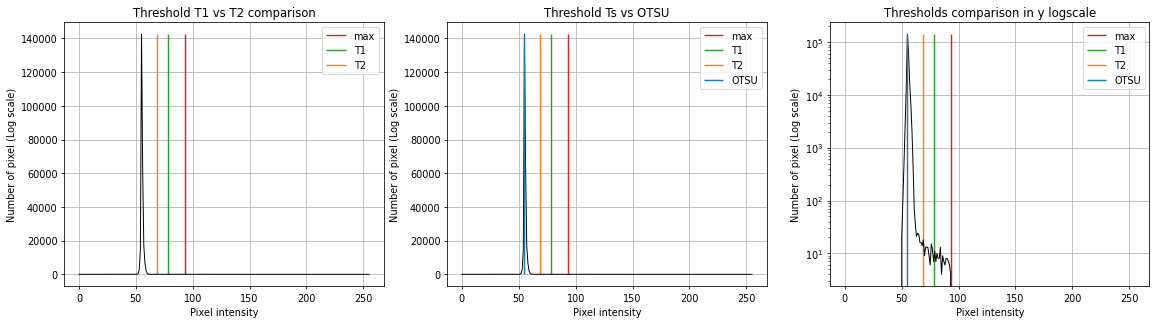

In [31]:
plotThresholds(img,sigma=sigma,k_gs_size=k_gs_size,alpha_power=alpha_power,p=p,eps=eps_seg)

Three subplots show the differences of the two thresholds estimated according to the maximum pixel value. Moreover they show also the different result gain with OTSU's algorithm. Indeed these images are generally uni-monodal, which implyes that OTSU's will fail to binarize them. 

$\Rightarrow$ this threshold is determined by minimizing intra-class intensity variance, or equivalently, by maximizing inter-class variance, but in uni-modal images this intra-class intensity is extremely hard to compute. 

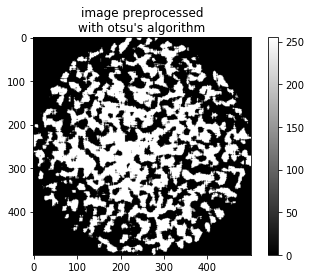

In [32]:
# preprocess the image
img_otsu = preprocess(img,
                      lambda x: cv2.threshold(x,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[0],
                      sigma=sigma, 
                      k_gs_size=k_gs_size,
                      alpha_power=alpha_power)
# plot the preprocessed image for centroid extraction
plot(img_otsu, 'image preprocessed\nwith otsu\'s algorithm')

Let's see instead another axample

In [33]:
file = os.path.join(tmp_folder, 'crab_sky011.png')
img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

If we plot the images we can see different results according to the threshold used:

* In the first case, for $T1$ an image with only two sources detcted

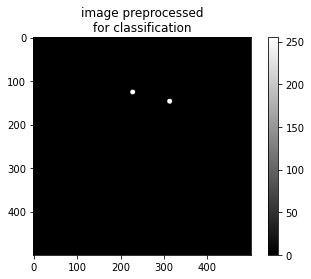

In [34]:
# preprocess the image
img_exs = preprocess_SVM(img)
# plot the preprocessed image for centroid extraction
plot(img_exs, 'image preprocessed\nfor classification')

* then, an image with three sources detected, thanks to $T2$.

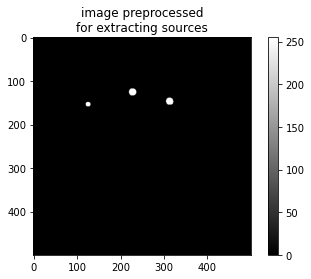

In [35]:
# preprocess the image
img_exs = preprocess_EXS(img)
# plot the preprocessed image for centroid extraction
plot(img_exs, 'image preprocessed\nfor extracting sources')

Of course the $T1$ cannot be able to detect all the sources in the images, due to the small fixed pixel window selected, but instead it can be very helpful to discriminate noise from at least one source!  

## Classifier Model

In [36]:
def flattening(Z):
    z_fl = []
    for i in range(len(Z)):
        z_fl.append(Z[i].flatten())
    return np.array(z_fl)

Let's now implement our classifier, which corresponds to a simple Support Vector Machine. The choise is due to the visualization showed in [Section 1.1](#PCA-for-plotting-data). Indeed SVM with 3 principal components succeeds to define an hyperplane for discriminate labels.

The model is fitted by implementing a Gridsearch with Cross Validation of a pipeline which implements the following 4 steps:
* Preprocessing for classifier with T1 threshold and flattening of data
* Principal Component Analysis with 3 principal components
* Support Vector Machine with rbf kernel

In [37]:
class preprocessorCLS(TransformerMixin, BaseEstimator):
    def __preprocess(self, X):
        if self.k_gs_size==-1:
            self.k_gs_size = int(np.ceil((3*self.sigma))*2+1)
        # Gaussian blur
        X1 = cv2.GaussianBlur(X, (self.k_gs_size,self.k_gs_size), self.sigma)
        # Gamma correction
        X1 = cv2.convertScaleAbs(X1, alpha=self.alpha_power)
        # Computing the threshold
        T = thresh4Label(X1, eps=self.eps_seg)
        # Binary segmentation
        ret2, X1 = cv2.threshold(X1,T,255,cv2.THRESH_BINARY)
        return X1
    
    def __init__(self, eps_seg=10, sigma=1, k_gs_size=5, alpha_power=0.2):
        # initialization of model attributes
        self.sigma = sigma
        self.eps_seg = eps_seg
        self.k_gs_size = k_gs_size
        self.alpha_power = alpha_power
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return flattening([self.__preprocess(x) for x in X])

BEST PARAMS THAT
```
{'pca__n_components': 3,
 'preprocessor__alpha_power': 1,
 'preprocessor__eps_seg': 14,
 'preprocessor__k_gs_size': 15,
 'preprocessor__sigma': 6,
 'svc__C': 0.1,
 'svc__gamma': 1e-06,
 'svc__kernel': 'rbf'}
 ```

In [38]:
if not from_pretrained:
    pca = PCA()
    svc=svm.SVC(probability=True)
    pipe = Pipeline(steps=[('preprocessor', preprocessorCLS()),
                           ('pca', pca),
                           ('svc', svc)])
    param_grid={
        'preprocessor__sigma':[sigma],
        'preprocessor__k_gs_size':[k_gs_size],
        'preprocessor__alpha_power':[alpha_power],
        'preprocessor__eps_seg':[14,15,16],
        'pca__n_components':[3],
        'svc__C':[0.1, 0.5],
        'svc__gamma':[1e-6, 1e-5, 1e-3],
        'svc__kernel':['rbf']
    }
    classifier=GridSearchCV(pipe, param_grid, cv=3,
                            scoring=['accuracy', 'f1'], refit='accuracy', 
                            return_train_score=True, verbose=10)

Let's fit the classifier model

In [39]:
if not from_pretrained:
    # fit the model
    classifier.fit(X_data_train, y_label_train)
    # serialize (save) the model
    joblib.dump(classifier, os.path.join(out_models_folder, 'classifier.pkl'), compress=1)
    classifier = joblib.load(os.path.join(out_models_folder, 'classifier.pkl'))
else:
    # load the model pre-fitted
    classifier = joblib.load(os.path.join(out_models_folder, 'classifier.pkl'))

These are the best parameters

In [40]:
print('Best parameters are:')
best_params = classifier.best_params_
best_params

Best parameters are:


{'pca__n_components': 3,
 'preprocessor__alpha_power': 1,
 'preprocessor__eps_seg': 14,
 'preprocessor__k_gs_size': 15,
 'preprocessor__sigma': 6,
 'svc__C': 0.1,
 'svc__gamma': 1e-06,
 'svc__kernel': 'rbf'}

### Evaluation

In order to evaluate this model, accuracy and f1_score were been used, showing following results

In [41]:
# label predicted by the classifier
y_label_train_pred = classifier.predict(X_data_train)
y_label_test_pred = classifier.predict(X_data_test)
# accuracy
train_acc = accuracy_score(y_label_train, y_label_train_pred)
print("Train set accuracy:", train_acc)
test_acc = accuracy_score(y_label_test, y_label_test_pred)
print("Test set accuracy :", test_acc)
print("#"*3)
# f1 score
train_f1 = f1_score(y_label_train, y_label_train_pred)
print("Train set f1 score:", train_f1)
test_f1 = f1_score(y_label_test, y_label_test_pred)
print("Test set f1 score :", test_f1)

Train set accuracy: 0.9986666666666667
Test set accuracy : 1.0
###
Train set f1 score: 0.9986824769433464
Test set f1 score : 1.0


Following there is the confusion matrix of the test set for `Label` prediciton. As we can see the results are not so much good, but this is due to the fact we are not adding preprocessing in our classification.

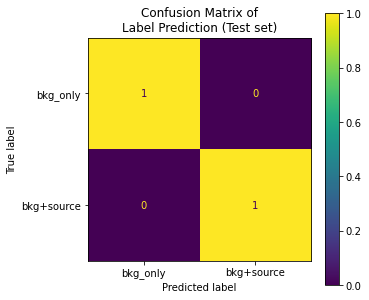

In [42]:
# Confusion matrix of Label results
fig, ax=plt.subplots(1,1,figsize=(5,5))
plt.grid(False)
# Plot the confusion matrix normalizing over the true values (over the rows)
cm = confusion_matrix(y_label_test, y_label_test_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bkg_only', 'bkg+source'])
disp.plot(ax=ax, cmap='viridis')
plt.title('Confusion Matrix of\nLabel Prediction (Test set)')
plt.show()

## Centroid Extractor Model 

A little recap of the dataset

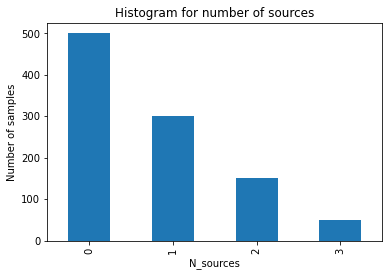

In [43]:
plt.title('Histogram for number of sources')
plt.ylabel('Number of samples')
df.groupby(['File_name', 'N_sources'], as_index=False).count() \
  .groupby('N_sources')['N_sources'].count().plot.bar()
plt.show()

### Metric definitions

Here I define a set of metrics, which can be used in order to compute the Cross Validation on the extractor model. The set of metrics consists of:
* _Angular Error Loss_: which computes the separation between predicted and real sources. Of course this is a score which must be minimized, so the lower is the better
* _Accuracy on number of coords predicted_: this is an accuracy which take into accounts the number of coordinates predicted
* _F1 score on number of coords predicted_: same as before but with f1 score

In [44]:
def angularError(yt, yp):
    # standard point used in case of mismatches
    point_std = SkyCoord(ra=-90*u.degree, dec=-90*u.degree, frame='icrs')
    # copy of predictions 
    yp1 = yp.copy()
    len_yt = len(yt)
    len_yp = len(yp)
    # let's take the same size for the two lists of coordinates
    if len_yt < len_yp:
        for _ in range(len_yp - len_yt):
            yt.append(point_std)
    elif len_yt > len_yp:
        for _ in range(len_yt - len_yp):
            yp1.append(point_std)
    # intializes the outputs
    angular_err = []
    # iterate over all the possible couple c1 and c2
    for c1 in yt:
        candidate_list = []
        for c2 in yp1:
            # compute a list of candidates for matches
            candidate_list.append(c1.separation(c2).radian)
        # save the candidate with minimum separation
        i_min = np.argmin(candidate_list)
        # if c1 or c2 is equal to the standard point save as error 
        # the maximum separation value (i.e. pi) 
        if c1 == point_std or c2 == point_std:
            angular_err.append(np.pi)
        else:
            angular_err.append(candidate_list[i_min])
        # discard the selected candidate
        yp1.remove(yp1[i_min])
    # finally if the sum of the angular error is equal zero (e.g. after good 
    # label prediction as bkg_only)
    if len(angular_err) == 0:
        # return the sum
        return np.sum(angular_err)
    else:
        # otherwise return the mean
        return np.mean(angular_err)

def angularErrorLoss(y_true, y_pred):
    # return the mean of the angular value over all samples
    return np.mean([angularError(y[0], y[1]) for y in zip(y_true, y_pred)])

In [45]:
def accuracyCoordsScore(y_true, y_pred):
    # computes the accuracy on the length of predicted and true coordinates
    gold_Nsources = [len(y_true[i]) for i in range(len(y_true))]
    pred_Nsources = [len(y_pred[i]) for i in range(len(y_pred))]
    return accuracy_score(gold_Nsources, pred_Nsources)

In [46]:
def f1CoordsScore(y_true, y_pred):
    # computes the f1 score on the length of predicted and true coordinates
    gold_Nsources = [len(yt) for yt in y_true]
    pred_Nsources = [len(yp) for yp in y_pred]
    print(f1_score(gold_Nsources, pred_Nsources, average='macro'))
    return f1_score(gold_Nsources, pred_Nsources, average='macro')

`make_scorer` converts the functions previously defined in score functions which can be used during the Cross Validation. If `greater_is_better = False` (`True`) the score must be minimized (maximized) because it a loss (score) function.

In [47]:
# turn as score the custom loss
angular_error_loss    = make_scorer(angularErrorLoss, greater_is_better=False)
# turn as score the custom metrics
accuracy_coords_score = make_scorer(accuracyCoordsScore, greater_is_better=True)
f1_coords_score       = make_scorer(f1CoordsScore, greater_is_better=True)

### Training

Let's define the new model we use to extract the predictions in every image

* The extraction algorithm computes contours and momentums for each blob found from the new preprocessed image, to extract the centroids directly. This is implemented by performing ad-hock instructions from the library OpenCV.
* `cv2.findContours` extracts all the contours $c$ in a preprocessed image, while for each contour $c$ centroid’s coordinates $\gamma_c = (c_\bar{x}, c_\bar{y})$ are computed accordingly to the formula to find its barycenter
as following, by using the instruction `cv2.moments` in order to computes contours’ momentums:

\begin{align*}
    \gamma_c &= \begin{bmatrix}
               c_{\bar{x}} \\
               c_{\bar{y}} 
            \end{bmatrix}
        = \begin{bmatrix}
               \Big \lfloor \frac{M_{10}(c)}{M_{00}(c)} \Big \rfloor \\\\
               \Big \lfloor \frac{M_{01}(c)}{M_{00}(c)} \Big \rfloor 
           \end{bmatrix}
        = \begin{bmatrix}
               \Big \lfloor \frac{\sum_{p \in c}i}{A_c} \Big \rfloor \\\\
               \Big \lfloor \frac{\sum_{p \in c}j}{A_c} \Big \rfloor 
           \end{bmatrix}
\end{align*}

In [48]:
class Extractor(TransformerMixin, BaseEstimator):
    def __init__(self, p=90, sigma=1, k_gs_size=5, alpha_power=1, wcs=None):
        # initialization of model attributes
        self.sigma = sigma
        self.p = p
        self.k_gs_size = k_gs_size
        self.alpha_power = alpha_power
        self.wcs = wcs
    
    def __preprocess(self, X):
        if self.k_gs_size==-1:
            self.k_gs_size = int(np.ceil((3*self.sigma))*2+1)
        # Gaussian blur
        X1 = cv2.GaussianBlur(X, (self.k_gs_size,self.k_gs_size), self.sigma)
        # Gamma correction
        X1 = cv2.convertScaleAbs(X1, alpha=self.alpha_power)
        # Computing the threshold
        T = thresh4SrcExtraction(X1, p=self.p)
        # Binary segmentation
        _, X1 = cv2.threshold(X1,T,255,cv2.THRESH_BINARY)
        return X1
    
    def transform(self, X, y = None):
        return flattening([self.__preprocess(x) for x in X])
    
    def __findCentroid(self, X_pp):
        # extracts the contours from the image preprocessed
        contours = cv2.findContours(X_pp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
        centroids = []
        for c in contours:
            # compute the moments up to the third order of the contours of the image
            M = cv2.moments(c)
            if M["m00"] != 0:
                # calculate x,y coordinate of centroid for the current contour
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                # convert the pixel integer coordinates in astronomycal coordinates 
                wcs_coords = self.wcs.pixel_to_world(cX, cY)
                centroids.append(wcs_coords)
        return centroids

    def __getCentroids(self, X):
        # checks if the image X contains at least one source, 
        # preprocess_SVM is applyed for this task
        if classifier.predict([X])[0] == np.array([1]):
            # extract sources' centroids, preprocess preprocess_EXS 
            # is applyied 
            return self.__findCentroid(self.__preprocess(X))
        else:
            return[]

    def fit(self, X, y = None):
        y_pred = [self.__getCentroids(x) for x in tqdm(X)]
        return y_pred
    
    def predict(self, X):
        y_pred = [self.__getCentroids(x) for x in X]
        return y_pred

Let's start the new Gridsearch. Best parameters of the classifier are used to instantiate the object Extractor, in order to make a faster and bigger search over the possible values of the parameter `p` 

In [49]:
low=97
high=99
param_grid={
    'p':np.arange(low, high, 0.05)
}
wcs = WCS(X_file_train[0])
best_extr = GridSearchCV(Extractor(sigma=best_params['preprocessor__sigma'],
                                   k_gs_size=best_params['preprocessor__k_gs_size'],
                                   alpha_power=best_params['preprocessor__alpha_power'],
                                   wcs=wcs), 
                         param_grid, cv=3,
                         scoring=accuracy_coords_score, 
                         return_train_score=True, verbose=10)

and fit the model 

In [50]:
if not from_pretrained:
    # fit the model
    best_extr.fit(X_data_train, y_coord_train)
else:
    # load the model pre-fitted
    best_extr = joblib.load(os.path.join(out_models_folder, 'extractor.pkl'))

In [51]:
best_extr.best_params_

{'p': 97.0}

Let's save the model

In [52]:
if not from_pretrained:
    # serialize (save) the model
    best_extr = joblib.load(os.path.join(out_models_folder, 'extractor.pkl'))

### Evaluation

let's predict the coordinates with the predicted model

In [53]:
y_coord_train_pred = best_extr.best_estimator_.predict(X_data_train)
y_coord_test_pred = best_extr.best_estimator_.predict(X_data_test)

We can also compute the metrics defined before on last predictions

In [54]:
train_acc = accuracyCoordsScore(y_coord_train, y_coord_train_pred)
print("Train set accuracy:          ", train_acc)
test_acc = accuracyCoordsScore(y_coord_test, y_coord_test_pred)
print("Test set accuracy:           ", test_acc)
print("#"*3)
train_f1 = f1CoordsScore(y_coord_train, y_coord_train_pred)
print("Train set f1 score:          ", train_f1)
test_f1 = f1CoordsScore(y_coord_test, y_coord_test_pred)
print("Test set f1 score:           ", test_f1)
print("#"*3)
train_aloss = angularErrorLoss(y_coord_train, y_coord_train_pred)
print("Train set angular error mean:", train_aloss)
test_aloss  = angularErrorLoss(y_coord_test, y_coord_test_pred)
print("Test set angular error mean: ", test_aloss)

Train set accuracy:           0.9706666666666667
Test set accuracy:            0.988
###
0.9516266115370258
Train set f1 score:           0.9516266115370258
0.9758239008239009
Test set f1 score:            0.9758239008239009
###
Train set angular error mean: 0.0922920462154835
Test set angular error mean:  0.037839637428942086


The confusion matrix shows how under certain hypothesis given by the instance of the task already specifyed we can achive extremly good results

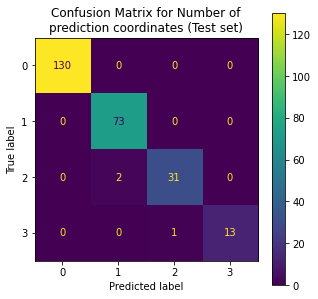

In [55]:
# Confusion matrix of Label results
fig, ax=plt.subplots(1,1,figsize=(5,5))
plt.grid(False)
# Plot the confusion matrix normalizing over the true values (over the rows)
cm = confusion_matrix([len(y_coord_test[i]) for i in range(len(y_coord_test))], 
                      [len(y_coord_test_pred[i]) for i in range(len(y_coord_test_pred))])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='viridis')
plt.title('Confusion Matrix for Number of\nprediction coordinates (Test set)')
plt.show()

Angular error among predicted-real centroids coordinates' details

In [56]:
aloss_vec = [angularError(y[0], y[1]) for y in zip(y_coord_train, y_coord_train_pred)]
print('max ',np.max(aloss_vec), '->', '\n\t', 
      y_coord_train[np.argmax(aloss_vec)], '\n\t',
      y_coord_train_pred[np.argmax(aloss_vec)])
print('min ',np.min(aloss_vec), '->', '\n\t', 
      y_coord_train[np.argmin(aloss_vec)], '\n\t', 
      y_coord_train_pred[np.argmin(aloss_vec)])
print('mean',np.mean(aloss_vec))
print('std ',np.std(aloss_vec))

max  3.141592653589793 -> 
	 [<SkyCoord (ICRS): (ra, dec) in deg
    (83.61473728, 20.9687583)>, <SkyCoord (ICRS): (ra, dec) in deg
    (81.28764648, 25.30935652)>] 
	 [<SkyCoord (ICRS): (ra, dec) in deg
    (83.64380499, 20.96449964)>]
min  0.0 -> 
	 [] 
	 []
mean 0.0922920462154835
std  0.5300854836586394


The following plot shows graphically the locality, spread and skewness of the predicted angular error.

[]

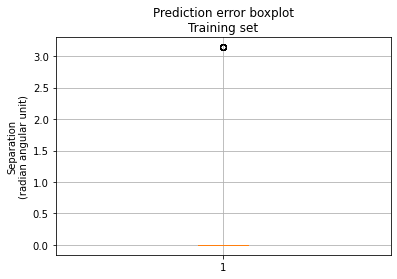

In [57]:
plt.title('Prediction error boxplot\nTraining set')
plt.grid(True)
plt.ylabel('Separation\n(radian angular unit)')
plt.boxplot([angularError(y[0], y[1]) for y in zip(y_coord_train, y_coord_train_pred)])
plt.plot()

Forgiving some outliars, the error is almost always low than 15e-4

[]

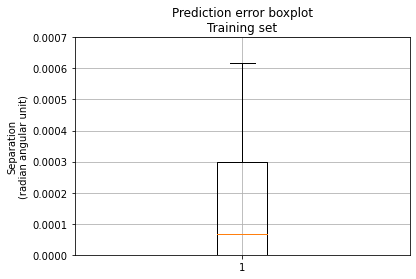

In [58]:
plt.title('Prediction error boxplot\nTraining set')
plt.grid(True)
plt.ylabel('Separation\n(radian angular unit)')
plt.ylim(0, 0.0007)
plt.boxplot([angularError(y[0], y[1]) for y in zip(y_coord_train, y_coord_train_pred)])
plt.plot()

Below angular error details over the test set

In [59]:
aloss_vec = [angularError(y[0], y[1]) for y in zip(y_coord_test, y_coord_test_pred)]
print('max ',np.max(aloss_vec), '->', '\n\t', 
      y_coord_test[np.argmax(aloss_vec)], '\n\t', 
      y_coord_test_pred[np.argmax(aloss_vec)])
print('min ',np.min(aloss_vec), '->', '\n\t', 
      y_coord_test[np.argmin(aloss_vec)], '\n\t', 
      y_coord_test_pred[np.argmin(aloss_vec)])
print('mean',np.mean(aloss_vec))
print('std ',np.std(aloss_vec))

max  3.141592653589793 -> 
	 [<SkyCoord (ICRS): (ra, dec) in deg
    (81.21110017, 20.89109331)>, <SkyCoord (ICRS): (ra, dec) in deg
    (81.97070723, 22.25279301)>, <SkyCoord (ICRS): (ra, dec) in deg
    (81.04073606, 20.65279334)>] 
	 [<SkyCoord (ICRS): (ra, dec) in deg
    (81.97992331, 22.25604835)>, <SkyCoord (ICRS): (ra, dec) in deg
    (81.14227042, 20.76510887)>]
min  0.0 -> 
	 [] 
	 []
mean 0.037839637428942086
std  0.34205768876750514


[]

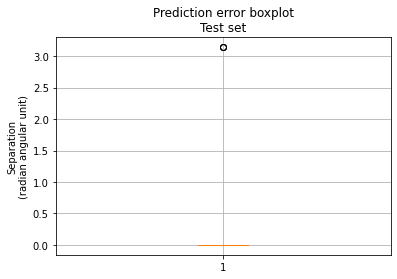

In [60]:
plt.title('Prediction error boxplot\nTest set')
plt.grid(True)
plt.ylabel('Separation\n(radian angular unit)')
plt.boxplot([angularError(y[0], y[1]) for y in zip(y_coord_test, y_coord_test_pred)])
plt.plot()

[]

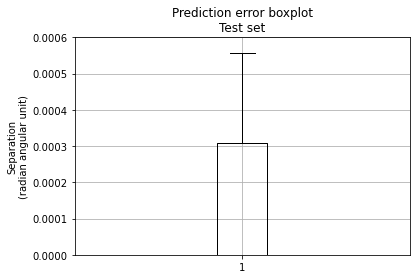

In [61]:
plt.title('Prediction error boxplot\nTest set')
plt.grid(True)
plt.ylim(0, 0.0006)
plt.ylabel('Separation\n(radian angular unit)')
plt.boxplot([angularError(y[0], y[1]) for y in zip(y_coord_test, y_coord_test_pred)])
plt.plot()

#### Extreme case

Could happen that some images are not well detected by the extractor, e.g. let's have a look at this extreme case. Assume to preprocess the following file. 

In [62]:
file_overlap = 'crab_sky142.fits'
file_no_overlap = 'crab_sky021.fits'

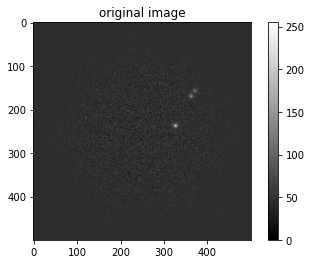

In [63]:
file = os.path.join(data_folder_skymap, file_overlap)
# open the skymap
hdul = fits.open(file)
# and convert it from .fits to .png
img = fits2png(hdul[0].data, file_overlap)
# close the skymap
hdul.close()
# plot the png generated image
plot(img, 'original image')

As you can see applying the preprocessing, in particular the Gaussian Smoothing, it will turn into a fusion of two sources of them. This happens because of the bluring of the image which tends to enlarge the shape of the image content while noise is suppressed. Of course this process will make to object converge if they are too cloose one to each other.

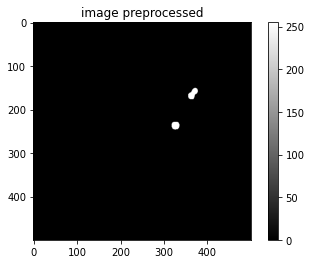

In [64]:
# preprocess the image
img = preprocess_EXS(img)
# plot the preprocessed image for centroid extraction
plot(img, 'image preprocessed')

# Plot predictions

In [65]:
def plotCentroids(file, title=None, srcListReal=[], srcListPred=[],
                  xlabel='right ascension (deg)', 
                  ylabel='declination (deg)', 
                  plotImage=True, markSize=30,
                  fontsize=20, figsize=(5,5), cmap='magma'):
    # get map
    with fits.open(file) as hdul:
        wcs = WCS(hdul[0].header)
        data = hdul[0].data

    # plot the simulation image
    fig = plt.figure(figsize=figsize) 
    ax = plt.subplot(projection=wcs)
    if plotImage:
        alpha=1
    else:
        alpha=0
    img = plt.imshow(data, norm=SymLogNorm(1), interpolation='gaussian', cmap=cmap, alpha=alpha)
    ax.coords[0].set_format_unit(u.deg)
    ax.coords[1].set_format_unit(u.deg)
    
    # plot a dot in corrispondance of sources
    ax.scatter([np.float32(src.ra) for src in srcListReal], [np.float32(src.dec) for src in srcListReal], 
               markSize, color='blue', marker='+', transform=ax.get_transform('fk5'), 
               label='real centroids')
    ax.scatter([np.float32(src.ra) for src in srcListPred], [np.float32(src.dec) for src in srcListPred],
               markSize, color='red', marker='+', transform=ax.get_transform('fk5'), 
               label='predicted centroids')
    
    # axis
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.grid(color='grey', ls='solid')
    ax.legend()
    fig.tight_layout()
    hdul.close()
    return 

* The following plots show graphically predictions resulted in the skymap. The more red cross (predicted centroids) overlap the blue one (real centroids) the best is the prediction 

In [66]:
file = os.path.join(data_folder_skymap, file_no_overlap)
try:
    i = X_file_train.index(file)
    srcListReal = y_coord_train[i]
    srcListPred = y_coord_train_pred[i]
except:
    i = X_file_test.index(file)
    srcListReal = y_coord_test[i]
    srcListPred = y_coord_test_pred[i]
print()
print(os.path.basename(file))
print('#'*3, 'List of REAL sources')
print(srcListPred)
print()
print('#'*3, 'List of PREDICTED sources')
print(srcListReal)


crab_sky021.fits
### List of REAL sources
[<SkyCoord (ICRS): (ra, dec) in deg
    (84.41693707, 25.20264035)>, <SkyCoord (ICRS): (ra, dec) in deg
    (82.37798637, 23.63967696)>, <SkyCoord (ICRS): (ra, dec) in deg
    (84.01129218, 22.26405768)>]

### List of PREDICTED sources
[<SkyCoord (ICRS): (ra, dec) in deg
    (82.37466927, 23.6389685)>, <SkyCoord (ICRS): (ra, dec) in deg
    (84.40331937, 25.20388157)>, <SkyCoord (ICRS): (ra, dec) in deg
    (84.0090109, 22.26404121)>]


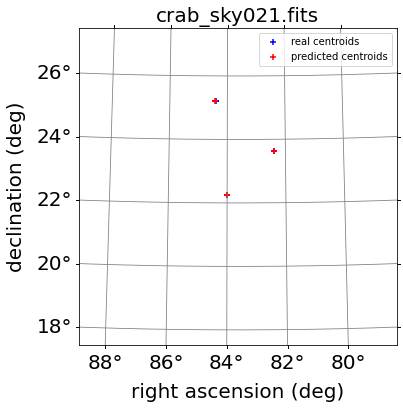

In [67]:
plotCentroids(file, title=os.path.basename(file), 
              srcListReal=srcListReal, srcListPred=srcListPred,
              plotImage=False)

* Sometimes could happen that the predictions make mistakes like the case reported above, where due to the preprocessing two sources where classyfied as one single. The final prediction will result in a red cross (prediction) among the two blue cross (real centroid)

In [68]:
file = os.path.join(data_folder_skymap, file_overlap)
try:
    i = X_file_train.index(file)
    srcListReal = y_coord_train[i]
    srcListPred = y_coord_train_pred[i]
except:
    i = X_file_test.index(file)
    srcListReal = y_coord_test[i]
    srcListPred = y_coord_test_pred[i]
print()
print(os.path.basename(file))
print('#'*3, 'List of REAL sources')
print(srcListPred)
print()
print('#'*3, 'List of PREDICTED sources')
print(srcListReal)


crab_sky142.fits
### List of REAL sources
[<SkyCoord (ICRS): (ra, dec) in deg
    (81.97992331, 22.25604835)>, <SkyCoord (ICRS): (ra, dec) in deg
    (81.14227042, 20.76510887)>]

### List of PREDICTED sources
[<SkyCoord (ICRS): (ra, dec) in deg
    (81.21110017, 20.89109331)>, <SkyCoord (ICRS): (ra, dec) in deg
    (81.97070723, 22.25279301)>, <SkyCoord (ICRS): (ra, dec) in deg
    (81.04073606, 20.65279334)>]


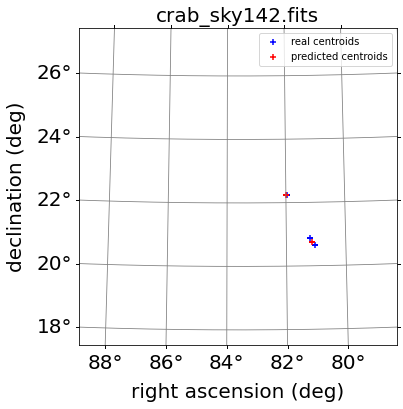

In [69]:
plotCentroids(file, title=os.path.basename(file), 
              srcListReal=srcListReal, srcListPred=srcListPred,
              plotImage=False)